# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
sys.path.append('/content/drive/MyDrive/Prak_MLMI')
sys.path.append('/content/drive/MyDrive')
sys.path.append('/content/drive/MyDrive/Prak_MLMI/model')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib.patches as patches

In [5]:
pip install torchray

     |████████████████████████████████| 378kB 6.7MB/s 
  Created wheel for torchray: filename=torchray-1.0.0.2-cp36-none-any.whl size=444027 sha256=b4e1b7953f34199795c4079ed3b1db40c052d47601c32296b94a95c4fad04622
  Stored in directory: /root/.cache/pip/wheels/49/21/6d/e6794f79658b66a0775b164fdd274b81a4c96e4eab5baaacb0
Successfully built torchray


In [6]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%reload_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize, Grayscale
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
  
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

label_path = '/content/drive/MyDrive/Prak_MLMI/model/labels'
import cxr_dataset as CXR
import merged_visualize_prediction as V
import pandas as pd

env: CUDA_VISIBLE_DEVICES=0


In [7]:
#!unzip "/content/drive/MyDrive/NIH_CXR14_Resized.zip" -d "/content/drive/MyDrive/NIH_CXR14_Resized"
!unzip "/content/drive/MyDrive/NIH_CXR14_Resized.zip" -d /content/

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/NIH small/00028897_014.png  
  inflating: /content/NIH small/00028897_015.png  
  inflating: /content/NIH small/00028897_016.png  
  inflating: /content/NIH small/00028897_017.png  
  inflating: /content/NIH small/00028897_018.png  
  inflating: /content/NIH small/00028897_019.png  
  inflating: /content/NIH small/00028897_020.png  
  inflating: /content/NIH small/00028898_000.png  
  inflating: /content/NIH small/00028899_000.png  
  inflating: /content/NIH small/00028899_001.png  
  inflating: /content/NIH small/00028899_002.png  
  inflating: /content/NIH small/00028900_000.png  
  inflating: /content/NIH small/00028901_000.png  
  inflating: /content/NIH small/00028901_001.png  
  inflating: /content/NIH small/00028902_000.png  
  inflating: /content/NIH small/00028902_001.png  
  inflating: /content/NIH small/00028902_002.png  
  inflating: /content/NIH small/00028902_003.png  
  inflating: /content/NIH small/00028902_004.png  
  in

## Loading Data and Model

In [8]:
prak_dir = '/content/drive/MyDrive/Prak_MLMI'
imagenet_dir = '/content/drive/MyDrive/Prak_MLMI/imagenet'
PATH_TO_IMAGES = "/content/NIH small"
#PATH_TO_IMAGES = "/content/drive/MyDrive/NIH_CXR14_Resized/NIH small"
#PATH_TO_IMAGES = prak_dir + "/NIH small"   
#PATH_TO_IMAGES = "/content/drive/MyDrive/NIH small"  
MODEL_PATH = prak_dir + '/model/results/checkpoint_best'
PATH_TO_MODEL = prak_dir + '/model/results/checkpoint_best'


dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

POSITIVE_FINDINGS_ONLY=True
LABEL='Pneumonia'

dataloader, model= V.load_data(PATH_TO_IMAGES, LABEL, PATH_TO_MODEL, 'BBox', POSITIVE_FINDINGS_ONLY, label_path=label_path)
print("Cases for review:")
print(len(dataloader))



# checkpoint = torch.load(MODEL_PATH, map_location=dev)
# model = checkpoint['model'].module
model.to(dev).eval()
print(model)

Cases for review:
120
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [9]:
# load the data

# use imagenet mean,std for normalization
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

# data_transforms = {
#     'train': Compose([
#         Resize(224),
#         CenterCrop(224),
#         ToTensor(),
#         Normalize(mean, std)
#     ]),
#     'val': Compose([
#         Resize(224),
#         CenterCrop(224),
#         ToTensor(),
#         Normalize(mean, std)
#     ]),
# }



# bounding_box_transform = CXR.RescaleBB(224, 1024)

# LABEL='Pneumonia'

# dataset = CXR.CXRDataset(
#     path_to_images=PATH_TO_IMAGES,
#     fold='BBox',#fold='train'
#     transform=data_transforms['train'],
#     transform_bb=bounding_box_transform,
#     fine_tune=False,
#     label_path=label_path)  #finding=LABEL
# dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)
 

### Insert the bottleneck into the model for NIH

You can experiment with the location of the bottleneck.

In [10]:
iba = IBA(model.features.denseblock2.denselayer6)

In [11]:
iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [12]:
iba.estimate(model, dataloader, device=dev, n_samples=10, progbar=True)

In [33]:
def show_iba(label, img, target, idx, bbox):
    """
    Plots CXR, attribution map of CXR generated by IB 
    """
    fig, (ax2, ax) = plt.subplots(ncols=2, figsize=(14, 5))
    img = img[None].to(dev)
    np_img = tensor_to_np_img(img[0])

    cxr = img.data.cpu().numpy().squeeze().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    cxr = std * cxr + mean
    cxr = np.clip(cxr, 0, 1)

    rect_original = patches.Rectangle((bbox[0, 0], bbox[0, 1]), bbox[0, 2], bbox[0, 3], linewidth=2, edgecolor='r', facecolor='none', zorder=2)
  #  rect_original = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2)
    

    ax2.imshow(cxr)
    ax2.axis('off')
    ax2.set_title(idx[0])
    ax2.add_patch(rect_original) 



    iba.reverse_lambda = False
    iba.beta = 0.5
    #model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
 #   heatmap = iba.analyze(img, model_loss_closure(img, target))  
    heatmap = iba.analyze(img, model_loss_closure)  
    # show the heatmap
    plot_saliency_map(heatmap, np_img, ax = ax)
    method = "original IB"
    _ = ax.set_title('{} for category {}'.format(method, label), fontsize=8)
    plt.show()





In [35]:
def show_iba_new(label, img, target, idx, bbox):
    """
    Plots CXR, attribution map of CXR generated by IB 
    """
    fig, (ax2, ax) = plt.subplots(ncols=2, figsize=(14, 5))
    img = img[None].to(dev)
    np_img = tensor_to_np_img(img[0])

    cxr = img.data.cpu().numpy().squeeze().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    cxr = std * cxr + mean
    cxr = np.clip(cxr, 0, 1)

    rect_original = patches.Rectangle((bbox[0, 0], bbox[0, 1]), bbox[0, 2], bbox[0, 3], linewidth=2, edgecolor='r', facecolor='none', zorder=2)
  #  rect_original = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2)
    

    ax2.imshow(cxr)
    ax2.axis('off')
    ax2.set_title(idx[0])
    ax2.add_patch(rect_original) 



    iba.reverse_lambda = True
    iba.beta = 0.5
    #model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
 #   heatmap = iba.analyze(img, model_loss_closure(img, target))  
    heatmap = iba.analyze(img, model_loss_closure)  
    # show the heatmap
    plot_saliency_map(heatmap, np_img, ax = ax)
    method = "improved IB"
    _ = ax.set_title('{} for category {}'.format(method, label), fontsize=8)
    plt.show()

In [27]:
def model_loss_closure(input):
  loss = nn.BCEWithLogitsLoss()
  mse_loss = loss(model(input), torch.tensor(target).view(1,-1).expand(10, -1).to(dev).float())
#  mse_loss = loss(model(input), torch.tensor(target).view(1,-1).to(dev).float())
  return mse_loss

## Compare different methods 

In [16]:
%matplotlib inline

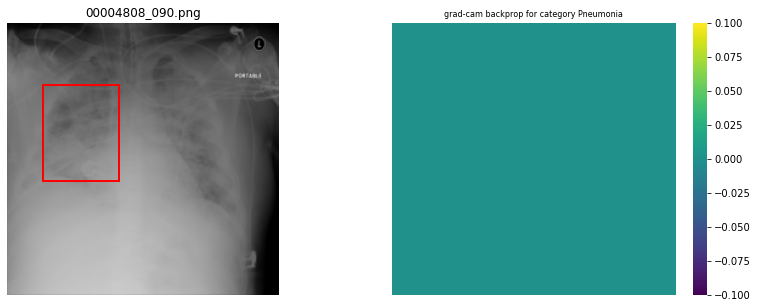

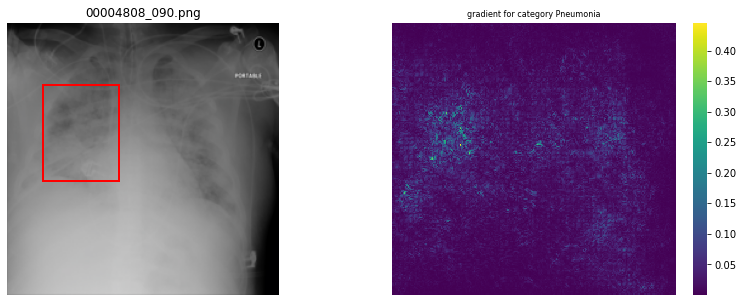

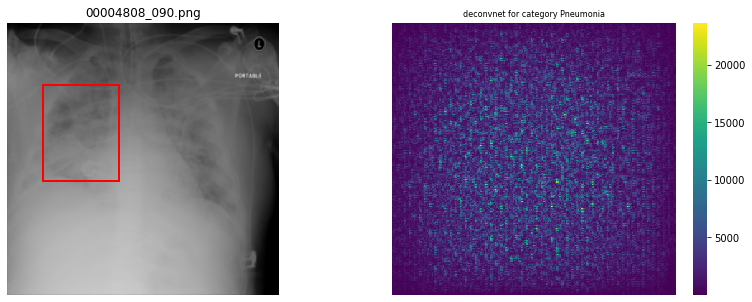

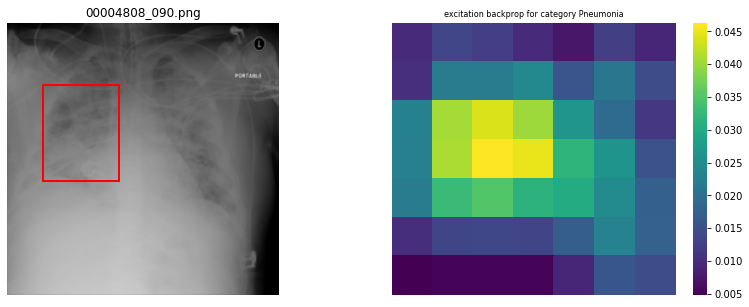

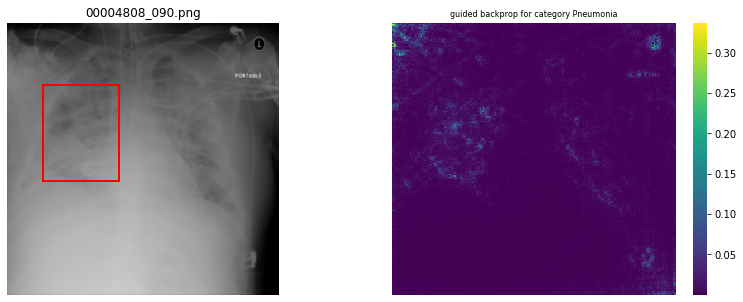

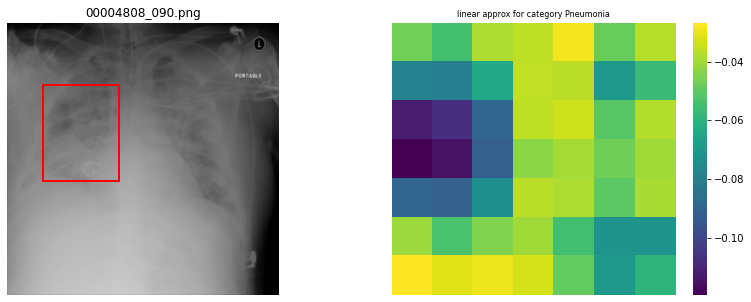

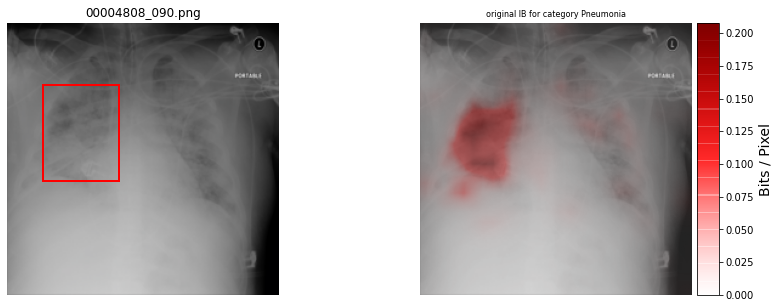

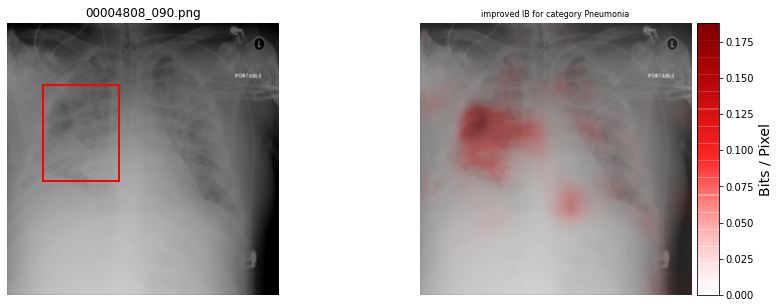

                   Predicted Probability  Ground Truth
Finding                                               
Infiltration                       0.545          True
Edema                              0.216          True
Nodule                             0.128         False
Effusion                           0.123         False
Consolidation                      0.099         False
Mass                               0.067         False
Pneumonia                          0.058          True
Cardiomegaly                       0.034         False
Atelectasis                        0.026         False
Pneumothorax                       0.011         False
Pleural_Thickening                 0.009         False
Fibrosis                           0.004         False
Emphysema                          0.002         False
Hernia                             0.001         False


In [38]:
inputs, labels, filename, bbox, preds = V.plot_map(model, dataloader, LABEL, saliency_layer='features.norm5')
target = labels.squeeze()
show_iba(LABEL, inputs.squeeze(), target, filename, bbox)
show_iba_new(LABEL, inputs.squeeze(), target, filename, bbox)
print(preds)


In [18]:
aoprint(labels)
print(filename)
print(bbox)
print(labels.squeeze())

tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
('00004344_002.png',)
tensor([[55, 65, 37, 85]], device='cuda:0', dtype=torch.int32)
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
print(labels.shape)
print(labels.squeeze().shape)

torch.Size([1, 14])
torch.Size([14])


In [ ]:
inputs.shape

torch.Size([1, 3, 224, 224])

In [ ]:
inputs.squeeze().shape

torch.Size([3, 224, 224])

In [ ]:
inputs.cpu().numpy().shape

(1, 3, 224, 224)

In [ ]:
labels.squeeze()

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
labels.squeeze().shape

torch.Size([14])

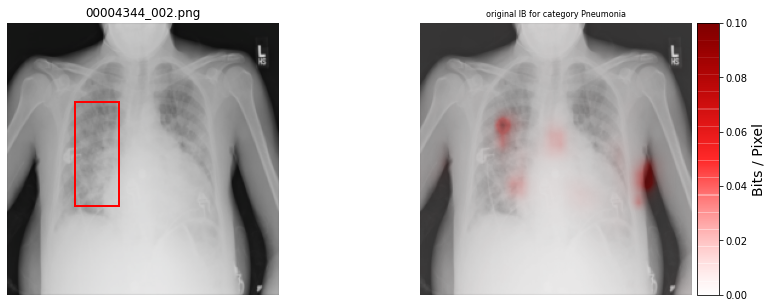

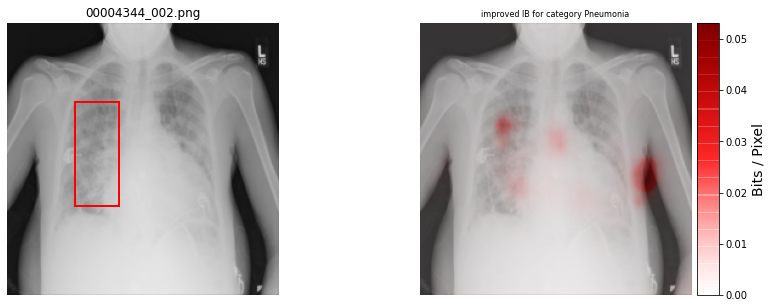

                   Predicted Probability  Ground Truth
Finding                                               
Infiltration                       0.406         False
Cardiomegaly                       0.316         False
Edema                              0.148         False
Consolidation                      0.097         False
Effusion                           0.088         False
Nodule                             0.077         False
Pneumonia                          0.053          True
Atelectasis                        0.016         False
Mass                               0.015         False
Pneumothorax                       0.013         False
Pleural_Thickening                 0.013         False
Fibrosis                           0.012         False
Emphysema                          0.002         False
Hernia                             0.001         False


In [37]:
target = labels.squeeze()
show_iba(LABEL, inputs.squeeze(), target, filename, bbox)
show_iba_new(LABEL, inputs.squeeze(), target, filename, bbox)
print(preds)